# Analysis - Simulation

In [1]:
from pathlib import Path
import numpy as np
import abtem
import tifffile
import json
import SingleOrigin as so
from matplotlib import pyplot as plt
import copy
import scipy
from utils import tk_popover, suppress_stdout


def minmax_norm(img):
    """Normalize a 2D array into the range [0, 1]"""
    # Underscores avoid overwriting reserved names
    _min, _max = np.min(img), np.max(img)
    return (img - _min) / (_max - _min)

In [ ]:
img_path = tk_popover(title="Select image...")
with tifffile.TiffFile(img_path) as tif:
    metadata = json.loads(tif.pages[0].tags["ImageDescription"].value)
img_raw = tifffile.imread(img_path)

# Cast to abTEM format for simple Fourier upscale (4x)
# Sampling is the Nyquist sampling for the probe used in the sim (saved in the .tif metadata)
sampling = metadata["axes"]["axis_0"]["sampling"]  # This assumes the sampling is the same on both axes (usually true)
img_abtem_format = abtem.measurements.Images(array=img_raw, sampling=(sampling, sampling))
img_interp = img_abtem_format.interpolate(sampling=(sampling/4, sampling/4))

# Cast to HRImage (SingleOrigin) format for further analysis
hrimg = so.HRImage(image=minmax_norm(img_interp.array))

# Preview
plt.imshow(hrimg.image)
plt.title(Path(img_path).stem)
plt.axis("off")
plt.show()

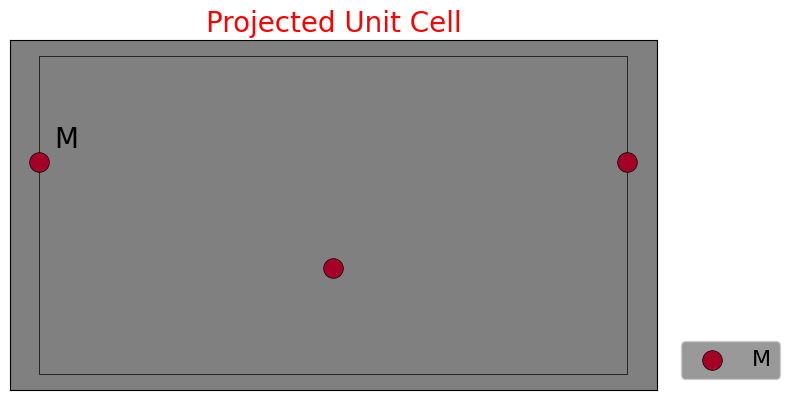

In [3]:
uc = so.UnitCell(path=tk_popover(), origin_shift=(0, 0, 0))
uc.atoms.replace("Al", "M", inplace=True)
with suppress_stdout():
    uc.project_zone_axis((1, 1, 0),  # Zone axis direction
                         (0, 0, 1),  # Apparent horizontal axis in projection
                         (1, -1, 0),  # Most vertical axis in projection
                         ignore_elements=["N"],
                         reduce_proj_cell=True)
    uc.combine_prox_cols(toler=1e-2)
uc.plot_unit_cell()
lattice = hrimg.add_lattice("AlGdN", uc, origin_atom_column=None)

  0%|          | 0/256 [00:00<?, ?it/s]C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 61 due to limitations of the operating system.
  warnings.warn(
100%|██████████| 256/256 [00:04<00:00, 53.87it/s]


0.086398077015823


(<Figure size 1300x1000 with 1 Axes>,
 <Axes: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

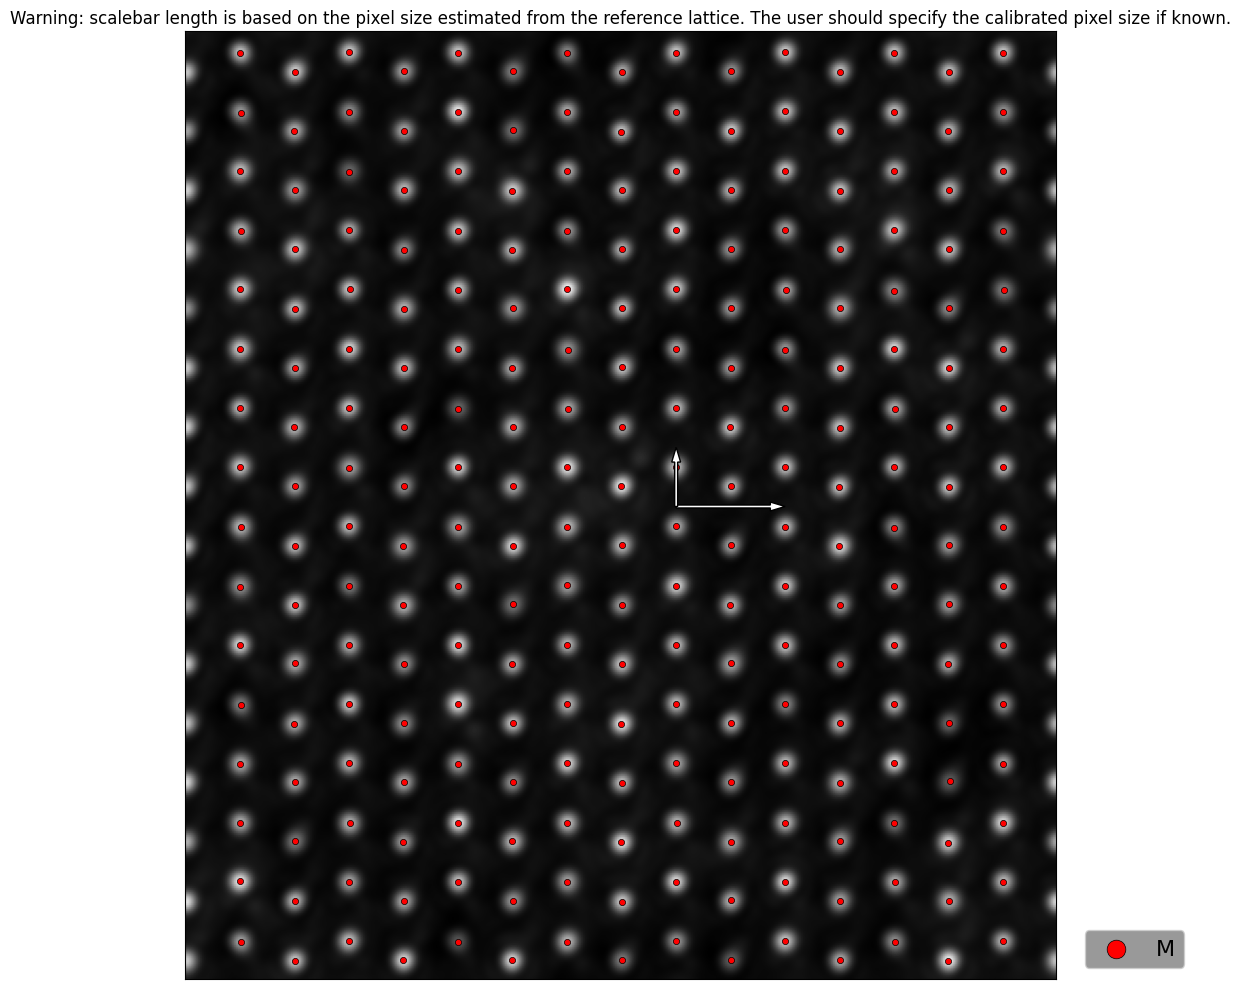

In [4]:
%matplotlib tk
with suppress_stdout():
    lattice.fft_get_basis_vect(a1_order=2,  # Order of peak corresponding to planes in the most horizontal direction
                               a2_order=3,  # Order of peak corresponding to planes in the most vertical direction
                               thresh_factor=0)  # Decrease to detect more peaks
    lattice.define_reference_lattice()

    lattice.fit_atom_columns(buffer=2,
                             bkgd_thresh_factor=0,
                             use_bounds=True,
                             pos_bound_dist=0.3,
                             use_circ_gauss=False,
                             parallelize=True,
                             peak_grouping_filter=None,
                             peak_sharpening_filter="auto")
    lattice.refine_reference_lattice(filter_by="elem",
                                     sites_to_use="M")
%matplotlib inline
hrimg.plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None, fit_or_ref="fit")

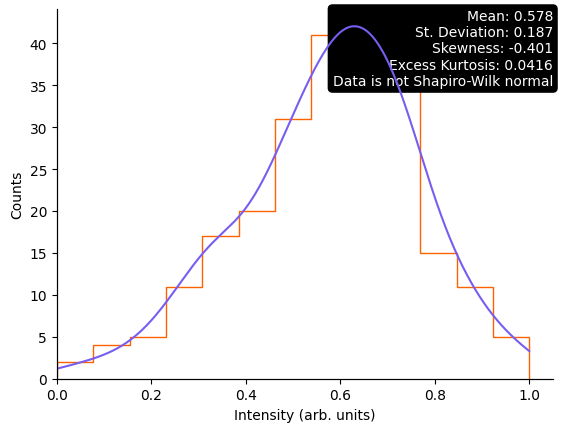

In [6]:
frame = copy.deepcopy(hrimg.latt_dict["AlGdN"].at_cols)
intensities = minmax_norm(np.array(frame["total_col_int"]))
summary_stats = scipy.stats.describe(intensities)

int_kernel = scipy.stats.gaussian_kde(intensities)
density_estimate = int_kernel.evaluate(np.linspace(summary_stats.minmax[0],
                                                   summary_stats.minmax[1],
                                                   1000))

fig, hax = plt.subplots()
kdeax = hax.twinx()
hax.hist(intensities, bins="auto", histtype="step", color="#fe6100")
hax.set_ylabel("Counts")
hax.set_xlabel("Intensity (arb. units)")
kdeax.plot(np.linspace(summary_stats.minmax[0], summary_stats.minmax[1], 1000),
           density_estimate, "-", c="#785ef0")
kdeax.set_yticks([])
kdeax.set_ylim(bottom=0)
hax.set_xlim(summary_stats.minmax[0]*0.95, summary_stats.minmax[1]*1.05)
hax.spines[["right", "top"]].set_visible(False)
kdeax.spines[["right", "top"]].set_visible(False)

# noinspection PyUnresolvedReferences
statstr = (f"Mean: {summary_stats.mean:.3g}\n"
           f"St. Deviation: {np.sqrt(summary_stats.variance):.3g}\n"
           f"Skewness: {summary_stats.skewness:.3g}\n"
           f"Excess Kurtosis: {summary_stats.kurtosis:.3g}\n"
           f"Data is{' not' if scipy.stats.shapiro(intensities)[1]<0.05 else ''} Shapiro-Wilk normal")
hax.text(1, 1, statstr, transform=hax.transAxes, verticalalignment="top", horizontalalignment="right",
         color="white", bbox={"boxstyle": "round", "facecolor": "black"})
plt.show()

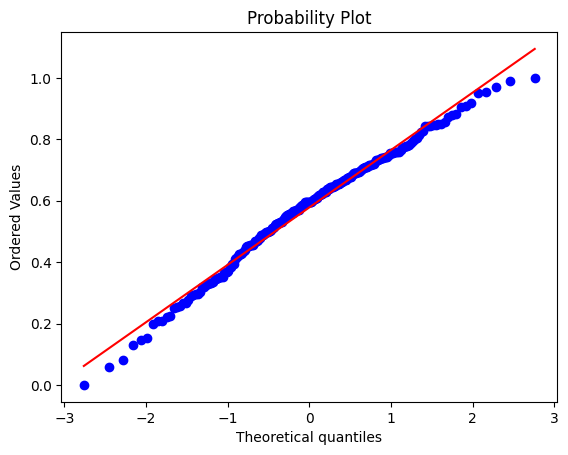

In [8]:
qq = scipy.stats.probplot(intensities, plot=plt)

# Analysis - Experimental

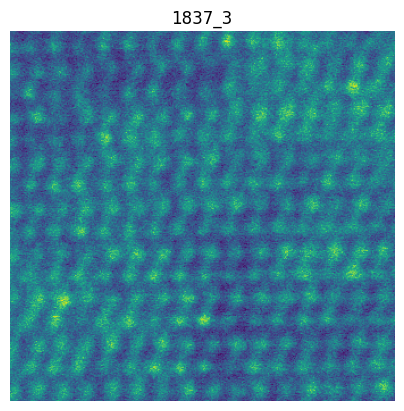

In [51]:
%matplotlib inline
img_path = tk_popover(title="Select image...")
img_raw = tifffile.imread(img_path)

# Cast to HRImage (SingleOrigin) format for further analysis
hrimg = so.HRImage(image=minmax_norm(img_raw))

# Preview
plt.imshow(hrimg.image)
plt.title(Path(img_path).stem)
plt.axis("off")
plt.show()
uc = so.UnitCell(path="E:/Users/Charles/AlN.cif", origin_shift=(0, 0, 0))
uc.atoms.replace("Al", "M", inplace=True)
with suppress_stdout():
    uc.project_zone_axis((1, 1, 0),  # Zone axis direction
                         (1, -1, 0),  # Apparent horizontal axis in projection
                         (0, 0, 1),  # Most vertical axis in projection
                         ignore_elements=["N"],
                         reduce_proj_cell=True)
    uc.combine_prox_cols(toler=1e-2)

lattice = hrimg.add_lattice("AlGdN", uc, origin_atom_column=None)
%matplotlib tk
# Selecting a reduced area to try to avoid thickness & mistilt effects
# lattice.get_roi_mask_polygon()
%matplotlib inline






  0%|          | 0/209 [00:00<?, ?it/s]C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 61 due to limitations of the operating system.
  warnings.warn(





 31%|███       | 64/209 [00:00<00:00, 154.16it/s]




 61%|██████    | 128/209 [00:04<00:03, 25.63it/s]




100%|██████████| 209/209 [00:04<00:00, 42.76it/s]


0.12271151650618253


(<Figure size 1300x1000 with 1 Axes>,
 <Axes: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

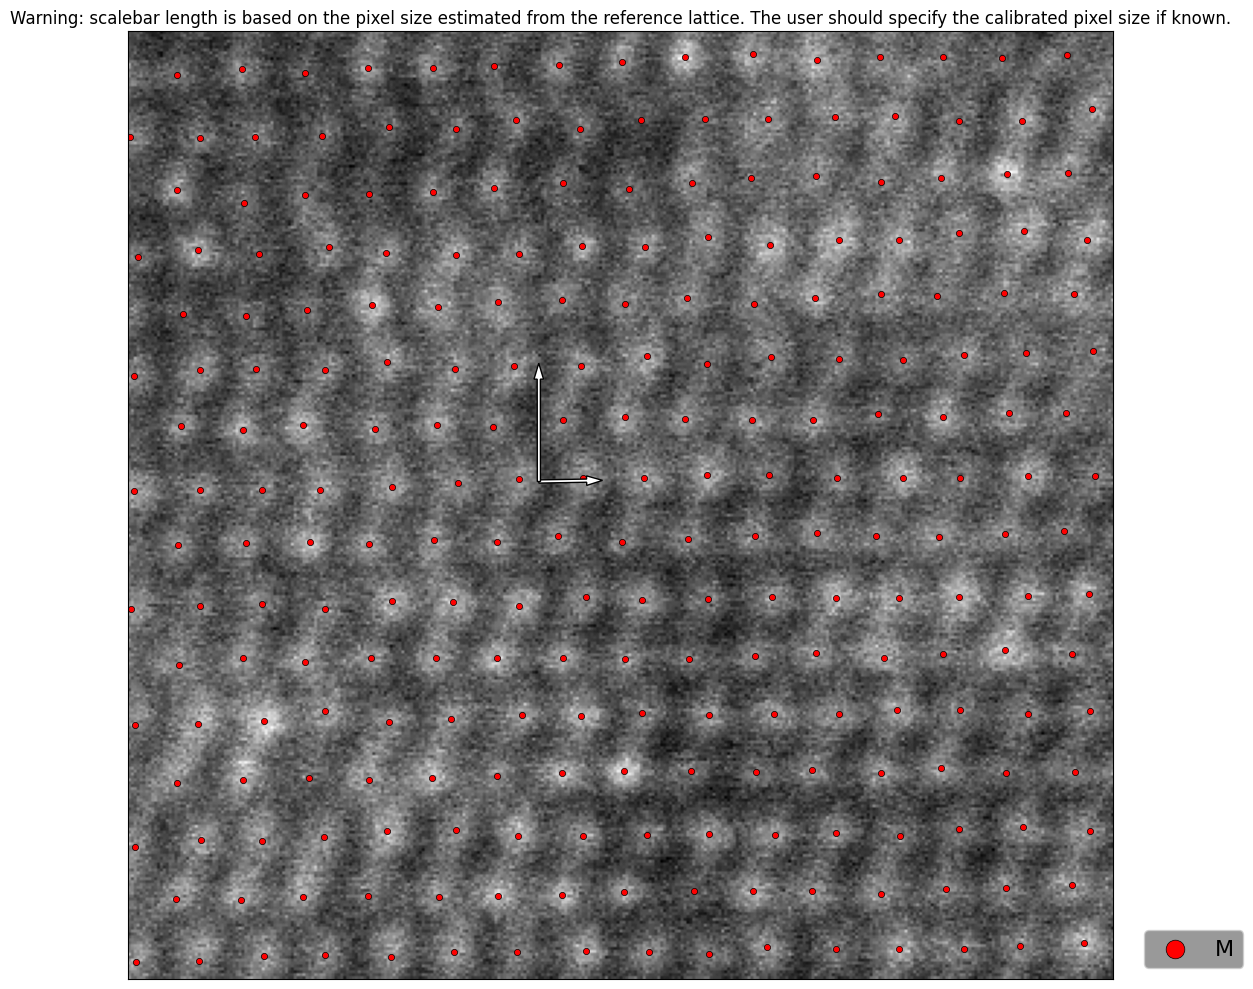

In [54]:
%matplotlib tk
with suppress_stdout():
    lattice.fft_get_basis_vect(a1_order=2,  # Order of peak corresponding to planes in the most horizontal direction
                               a2_order=2,  # Order of peak corresponding to planes in the most vertical direction
                               thresh_factor=0.0)  # Decrease to detect more peaks
    lattice.define_reference_lattice()

    lattice.fit_atom_columns(buffer=2,
                             bkgd_thresh_factor=0,
                             use_bounds=True,
                             pos_bound_dist=0.2,
                             use_circ_gauss=False,
                             parallelize=True,
                             peak_grouping_filter=None,
                             peak_sharpening_filter="auto")
    lattice.refine_reference_lattice(filter_by="elem",
                                     sites_to_use="M")
%matplotlib inline
hrimg.plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None, fit_or_ref="fit")

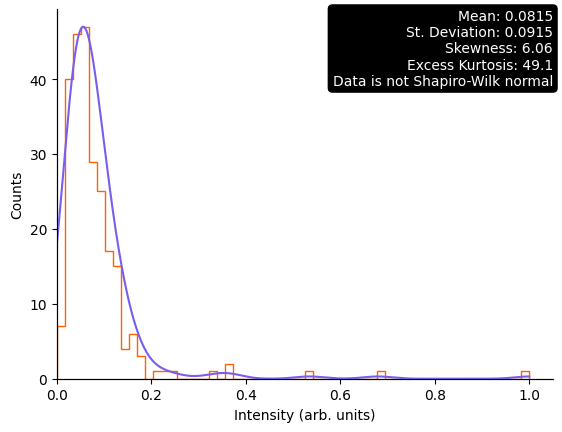

In [55]:
frame = copy.deepcopy(hrimg.latt_dict["AlGdN"].at_cols)
intensities = minmax_norm(np.array(frame["total_col_int"]))
summary_stats = scipy.stats.describe(intensities)

int_kernel = scipy.stats.gaussian_kde(intensities)
density_estimate = int_kernel.evaluate(np.linspace(summary_stats.minmax[0],
                                                   summary_stats.minmax[1],
                                                   1000))

fig, hax = plt.subplots()
kdeax = hax.twinx()
hax.hist(intensities, bins="auto", histtype="step", color="#fe6100")
hax.set_ylabel("Counts")
hax.set_xlabel("Intensity (arb. units)")
kdeax.plot(np.linspace(summary_stats.minmax[0], summary_stats.minmax[1], 1000),
           density_estimate, "-", c="#785ef0")
kdeax.set_yticks([])
kdeax.set_ylim(bottom=0)
hax.set_xlim(summary_stats.minmax[0]*0.95, summary_stats.minmax[1]*1.05)
hax.spines[["right", "top"]].set_visible(False)
kdeax.spines[["right", "top"]].set_visible(False)

# noinspection PyUnresolvedReferences
statstr = (f"Mean: {summary_stats.mean:.3g}\n"
           f"St. Deviation: {np.sqrt(summary_stats.variance):.3g}\n"
           f"Skewness: {summary_stats.skewness:.3g}\n"
           f"Excess Kurtosis: {summary_stats.kurtosis:.3g}\n"
           f"Data is{' not' if scipy.stats.shapiro(intensities)[1]<0.05 else ''} Shapiro-Wilk normal")
hax.text(1, 1, statstr, transform=hax.transAxes, verticalalignment="top", horizontalalignment="right",
         color="white", bbox={"boxstyle": "round", "facecolor": "black"})
plt.show()

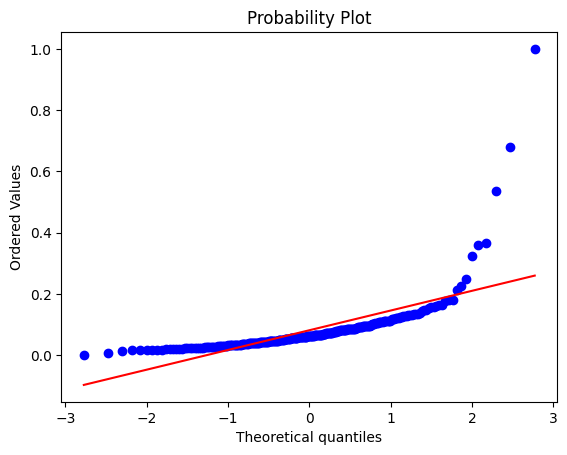

In [56]:
qq = scipy.stats.probplot(intensities, plot=plt)

We can also see what this distribution looks like with extreme (4$\sigma$) outliers removed

In [7]:
outlier_thresh = (max(0, summary_stats.mean - 4*np.sqrt(summary_stats.variance)),
                  min(1, summary_stats.mean + 4*np.sqrt(summary_stats.variance)))
ints_filtered = [i for i in intensities if outlier_thresh[0] < i < outlier_thresh[1]]  # Filter outliers
ints_filtered = minmax_norm(np.array(ints_filtered))  # Re-norm w/o outliers
summary_stats_filtered = scipy.stats.describe(ints_filtered)  # Re-calculate stats

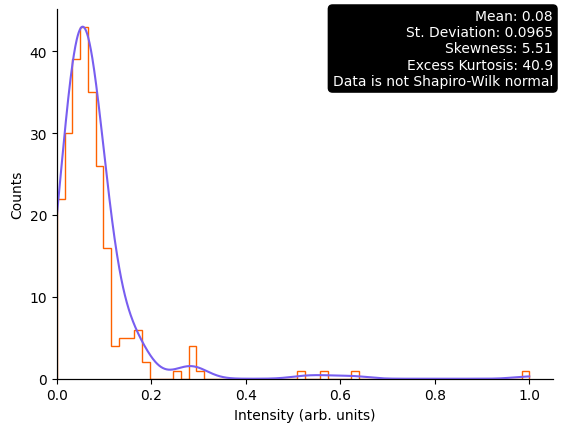

In [8]:
int_kernel = scipy.stats.gaussian_kde(ints_filtered)
density_estimate = int_kernel.evaluate(np.linspace(summary_stats_filtered.minmax[0],
                                                   summary_stats_filtered.minmax[1],
                                                   1000))

fig, hax = plt.subplots()
kdeax = hax.twinx()
hax.hist(ints_filtered, bins="auto", histtype="step", color="#fe6100")
hax.set_ylabel("Counts")
hax.set_xlabel("Intensity (arb. units)")
kdeax.plot(np.linspace(summary_stats_filtered.minmax[0], summary_stats_filtered.minmax[1], 1000),
           density_estimate, "-", c="#785ef0")
kdeax.set_yticks([])
kdeax.set_ylim(bottom=0)
hax.set_xlim(summary_stats_filtered.minmax[0]*0.95, summary_stats_filtered.minmax[1]*1.05)
hax.spines[["right", "top"]].set_visible(False)
kdeax.spines[["right", "top"]].set_visible(False)

# noinspection PyUnresolvedReferences
statstr = (f"Mean: {summary_stats_filtered.mean:.3g}\n"
           f"St. Deviation: {np.sqrt(summary_stats_filtered.variance):.3g}\n"
           f"Skewness: {summary_stats_filtered.skewness:.3g}\n"
           f"Excess Kurtosis: {summary_stats_filtered.kurtosis:.3g}\n"
           f"Data is{' not' if scipy.stats.shapiro(intensities)[1]<0.05 else ''} Shapiro-Wilk normal")
hax.text(1, 1, statstr, transform=hax.transAxes, verticalalignment="top", horizontalalignment="right",
         color="white", bbox={"boxstyle": "round", "facecolor": "black"})
plt.show()

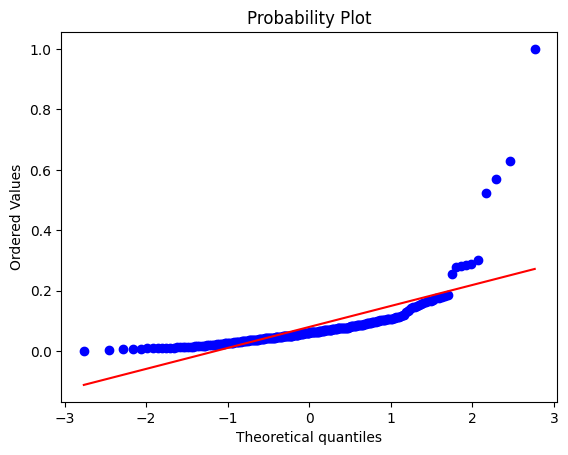

In [9]:
qq = scipy.stats.probplot(ints_filtered, plot=plt)